## Word-level language model

In the previous tasks you have written character-level language model. Time has come to grow up.

Word language models face a lot of new problems for you to solve. There are some of them:
  * How to read long texts (Gbs of data)
  * How to build vocabulry (and to effectively reduce its size)
  * How to deal with out-of-vocabulary (OOV) words
  * How to construct batch of _uncorrelated_ examples (not from the same text)
  * How and when to drop RNN state
  * What special tokens should be used? BOS? EOS?

**Results of this task:**
  * Text preprocessing
  * Batcher
  * Trained language model:
    * model should use truncated backpropagation through time
    * model should drop RNN state between different documents (eg. wikipedia articles)
  * Test set perplexity

**Additional points:**
  * Text preprocessing and batching that works with large files (does not load all the file to memory)
  * AWD-LSTM or other uncommon RNN architectures (SRU, QRNN)
  * Use popular dataset 

It is becoming common to use [byte-pair encoding](https://github.com/google/sentencepiece) to solve vocabulary problem. Use it! Here is an [example](https://github.com/google/sentencepiece/blob/master/python/sentencepiece_python_module_example.ipynb).

In [12]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm

import torch
import torch.nn as nn
from torch.autograd import Variable

import matplotlib.pyplot as plt
import scipy.stats as sps
import string
import sys

import sentencepiece as spm
import random

In [13]:
class Vocabulary:
    def __init__(self):
        self.w2i = dict()
        self.i2w = []
    def add_a_word(self, word):
        if word not in self.w2i:
            idx = len(self.w2i)
            self.w2i[word] = idx
            self.i2w.append(word)
    def get_an_idx(self, word):
        if word in self.w2i:
            return self.w2i[word]
        else: 
            return self.w2i["unk"]
    def get_a_word(self, idx):
        assert(idx < len(self.i2w))
        return self.i2w[idx]

In [25]:
def clean(line):
    table = str.maketrans('', '', string.punctuation)
    tokens = [w.translate(table) for w in line.split()]
    tokens = [w for w in tokens if w.isalpha()]
    tokens = [w.lower() for w in tokens]
    return tokens

In [77]:
class Corpus:
    def __init__(self, path):
        spm.SentencePieceTrainer.train('--input={} --model_prefix=m --user_defined_symbols=<s>,</s>,unk --vocab_size=2000'.format(path))

        self.sp = spm.SentencePieceProcessor()
        self.sp.load('m.model')
        
    def encode_file(self, file_path):
        f = open(file_path, "r")
        encoded = list()
        for line in f:
            tokens = clean(line)
            new_line = ' '.join(tokens)
            new_line = '<s>' + new_line + '</s>'
            temp = self.sp.encode_as_ids(new_line)
            encoded += temp
        return np.array(encoded);

In [78]:
corpus = Corpus('wiki.train.tokens')

In [91]:
valid_data = corpus.encode_file('wiki.valid.tokens')
train_data = corpus.encode_file('wiki.train.tokens')
test_data = corpus.encode_file('wiki.test.tokens')

In [62]:
print("Размер словаря: ", corpus.sp.get_piece_size())

Размер словаря:  5000


In [94]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, batch_size, sequence_size):
        super(RNN, self).__init__()
        self.hidden_size = (sequence_size, batch_size, hidden_size)
        self.embedding = nn.Embedding(vocab_size, emb_size)
        
        self.i2h = nn.Linear(emb_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(emb_size + hidden_size, vocab_size)
        self.o2o = nn.Linear(hidden_size + vocab_size, vocab_size)
        
        self.drop = nn.Dropout()
        
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        emb = self.embedding(input)
        input_combined = torch.cat((emb, hidden), 2)
        
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 2)
        
        output = self.o2o(output_combined)
        output = output[:-1]
        output = output.reshape(-1, output.shape[2])
        output = self.drop(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        hidden = torch.zeros(self.hidden_size)
        return torch.nn.init.xavier_uniform_(hidden)

In [95]:
criterion = nn.NLLLoss()

learning_rate = 1e-2

def train(batch, target):
    
    hidden = rnn.initHidden()
    rnn.zero_grad()

    loss = 0
    batch = torch.Tensor(batch).long()
    target = torch.Tensor(target).long()
    output, hidden = rnn(batch, hidden)
    
    loss = criterion(output, target)
    loss.backward()

    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
        
    return output, loss.item() / batch.shape[1]

In [96]:
def batcher(data, sequence_size = 60, batch_size = 5):
    data = np.array(data).T
    num_of_sequences = int(data.shape[0]//sequence_size)
    num_of_sequences = num_of_sequences//batch_size
    data = data[:num_of_sequences*sequence_size*batch_size]
    data = data.reshape(batch_size, num_of_sequences*sequence_size).T
    data = data.reshape(num_of_sequences, sequence_size, batch_size)
    data = list(data)
    random.shuffle(data)
    data = np.array(data)
    
    
    target = data.copy()[:, 1:, :]
    target = target.reshape(num_of_sequences, -1)
    return data, target

In [97]:
import gc
gc.collect()

1062

In [100]:
num_of_epoch = 5
batch_size = 16
sequence_size = 32

vocab_size = corpus.sp.get_piece_size()

rnn = RNN(vocab_size, 16, 32, batch_size, sequence_size)
all_losses = []

for _ in range(num_of_epoch):
    b_train = batcher(train_data, sequence_size, batch_size)
    n_batches = len(b_train[0])
    print_every = n_batches//20
    plot_every = n_batches//20
    
    for i in tqdm(range(n_batches)):
        _, loss = train(b_train[0][i], b_train[1][i])

        if i % print_every == 0:
            print('(%d %d%%) %.4f' % (i, i / n_batches * 100, loss))

        if i % plot_every == 0:
            all_losses.append(loss)

(0 0%) 0.4795
(326 4%) 0.4251
(652 9%) 0.4305
(978 14%) 0.4143
(1304 19%) 0.4238
(1630 24%) 0.4139
(1956 29%) 0.4255
(2282 34%) 0.4114
(2608 39%) 0.4141
(2934 44%) 0.3982
(3260 49%) 0.3999
(3586 54%) 0.4023
(3912 59%) 0.3995
(4238 64%) 0.4161
(4564 69%) 0.4127
(4890 74%) 0.4036
(5216 79%) 0.4126
(5542 84%) 0.4114
(5868 89%) 0.4065
(6194 94%) 0.4121
(6520 99%) 0.4033


(0 0%) 0.4082
(326 4%) 0.4086
(652 9%) 0.4067
(978 14%) 0.4133
(1304 19%) 0.4031
(1630 24%) 0.4050
(1956 29%) 0.4020
(2282 34%) 0.4126
(2608 39%) 0.4007
(2934 44%) 0.3863
(3260 49%) 0.3940
(3586 54%) 0.3928
(3912 59%) 0.4070
(4238 64%) 0.4047
(4564 69%) 0.3997
(4890 74%) 0.4187
(5216 79%) 0.4078
(5542 84%) 0.4051
(5868 89%) 0.4067
(6194 94%) 0.3986
(6520 99%) 0.3977


(0 0%) 0.4082
(326 4%) 0.3990
(652 9%) 0.4056
(978 14%) 0.4007
(1304 19%) 0.4064
(1630 24%) 0.4094
(1956 29%) 0.3965
(2282 34%) 0.4002
(2608 39%) 0.4007
(2934 44%) 0.4103
(3260 49%) 0.4044
(3586 54%) 0.4055
(3912 59%) 0.3875
(4238 64%) 0.4108
(4564 69%) 0.4058
(4890 74%) 0.4098
(5216 79%) 0.4060
(5542 84%) 0.3955
(5868 89%) 0.4113
(6194 94%) 0.3923
(6520 99%) 0.3875


(0 0%) 0.4072
(326 4%) 0.3853
(652 9%) 0.4080
(978 14%) 0.3986
(1304 19%) 0.3979
(1630 24%) 0.3984
(1956 29%) 0.3990
(2282 34%) 0.4016
(2608 39%) 0.4025
(2934 44%) 0.3984
(3260 49%) 0.4024
(3586 54%) 0.4025
(3912 59%) 0.4008
(4238 64%) 0.4138
(4564 69%) 0.4059
(4890 74%) 0.3961
(5216 79%) 0.4134
(5542 84%) 0.3902
(5868 89%) 0.4149
(6194 94%) 0.3923
(6520 99%) 0.3999


(0 0%) 0.3948
(326 4%) 0.3985
(652 9%) 0.3998
(978 14%) 0.3993
(1304 19%) 0.3975
(1630 24%) 0.4084
(1956 29%) 0.3883
(2282 34%) 0.3947
(2608 39%) 0.4080
(2934 44%) 0.4040
(3260 49%) 0.4061
(3586 54%) 0.3976
(3912 59%) 0.3995
(4238 64%) 0.3982
(4564 69%) 0.4037
(4890 74%) 0.4069
(5216 79%) 0.3938
(5542 84%) 0.4100
(5868 89%) 0.3908
(6194 94%) 0.3995
(6520 99%) 0.4046


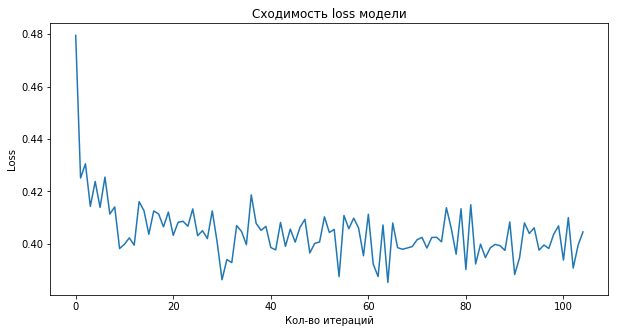

In [106]:
plt.figure(figsize = (10, 5))
plt.title("Сходимость loss модели")
plt.ylabel("Loss")
plt.xlabel("Кол-во итераций")
plt.plot(all_losses)
plt.show()

### Перплексия модели на настроечной выборке:

In [102]:
b_test = batcher(test_data, sequence_size, batch_size)

In [103]:
b_test[0].shape

(738, 32, 16)

In [111]:
def test(b_test):
    with torch.no_grad():
        rnn.eval()
        n_batches = len(b_test[0])
        loss = 0
        hidden = rnn.initHidden()
        
        for i in tqdm(range(n_batches)):
            batch = b_test[0][i]
            target = b_test[1][i]
            
            batch = torch.Tensor(batch).long()
            target = torch.Tensor(target).long()
            
            output, hidden = rnn(batch, hidden)

            loss += criterion(output, target) / batch.shape[1]

        return loss / n_batches

In [112]:
x = test(b_test)
print("Перплексия модели на настроечной выборке:", float(2**(x)))

Перплексия модели на настроечной выборке: 1.286025047302246
